In [ ]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=50e8ab6712a610062800608a78d1c26884090643105919f4fcbcacadfa21c31c
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
!pip install elephas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 963.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attemptin

In [ ]:
# Spark Session, Pipeline, Functions, and Metrics
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml import Pipeline
from pyspark.sql.functions import rand
from pyspark.mllib.evaluation import MulticlassMetrics

# Keras / Deep Learning
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers, regularizers
from keras.optimizers import Adam

# Elephas for Deep Learning on Spark
from elephas.ml_model import ElephasEstimator

In [ ]:
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [ ]:
features = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
            "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
            "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
            "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
            "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
            "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
            "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
            "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
            "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

In [ ]:
dataset = spark.read.csv("/content/corrected", inferSchema=True, header=False)

In [ ]:
dataset = dataset.toDF(*features)

In [ ]:
from pyspark.sql.functions import regexp_replace
dataset = dataset.withColumn("label", regexp_replace("label", "\.", ""))

In [ ]:
print("Dataset sizes: {row} samples, {cols} features".format(row=dataset.count(), cols=len(dataset.columns)))

Dataset sizes: 311029 samples, 42 features


In [ ]:
def find_categorical_columns(df):
    categorical_columns = [col for (col, data_type) in df.dtypes if data_type == "string"]
    return categorical_columns

In [ ]:
# Identify categorical columns in the DataFrame
categorical_columns = find_categorical_columns(dataset)

# Print the result
print("Categorical Columns:", categorical_columns)

Categorical Columns: ['protocol_type', 'service', 'flag', 'label']


In [ ]:
label = "label"

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
categorical_features = ["protocol_type", "service", "flag"]
'''indexers = [StringIndexer(inputCol=column, outputCol=column + "_num") for column in categorical_features]
indexers.append(StringIndexer(inputCol="label", outputCol="label_num"))
pipeline = Pipeline(stages=indexers)
dataset = pipeline.fit(dataset).transform(dataset)'''

'indexers = [StringIndexer(inputCol=column, outputCol=column + "_num") for column in categorical_features]\nindexers.append(StringIndexer(inputCol="label", outputCol="label_num"))\npipeline = Pipeline(stages=indexers)\ndataset = pipeline.fit(dataset).transform(dataset)'

In [ ]:
exclude_list = categorical_features + ["label"]
# print("Exclude list:")
print(exclude_list)

['protocol_type', 'service', 'flag', 'label']


In [ ]:
numerical_cols = [col for col in dataset.columns if col not in exclude_list]
print(numerical_cols)

['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [ ]:
'''df_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
dataset = df_assembler.transform(dataset)
dataset.printSchema()'''

'df_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")\ndataset = df_assembler.transform(dataset)\ndataset.printSchema()'

In [ ]:

# Check if "label_index" column already exists in the DataFrame
if "label_index" in dataset.columns:
    # Drop the existing "label_index" column
    dataset = dataset.drop("label_index")


In [ ]:
# Helper function to select features to scale given their skew
def select_features_to_scale(df=dataset, lower_skew=-2, upper_skew=2, dtypes='int32'):

    # Empty Selected Feature List for Output
    selected_features = []

    # Select Features to Scale based on Inputs ('in32' type, drop 'ID' columns or others, skew bounds)
    feature_list = list(df.toPandas().select_dtypes(include=[dtypes]))

    # Loop through 'feature_list' to select features based on Kurtosis / Skew
    for feature in feature_list:

        if df.toPandas()[feature].kurtosis() < -2 or df.toPandas()[feature].kurtosis() > 2:

            selected_features.append(feature)

    # Return feature list to scale
    return selected_features

In [ ]:
from pyspark.ml.feature import OneHotEncoder
# Pipeline Stages List
stages = []
# Loop for StringIndexer and OHE for Categorical Variables
for features in categorical_columns:
    # Index Categorical Features
    string_indexer = StringIndexer(inputCol=features, outputCol=features + "_index")

    # One Hot Encode Categorical Features
    encoder = OneHotEncoder(inputCols=[string_indexer.getOutputCol()],
                            outputCols=[features + "_class_vec"])

    # Append Pipeline Stages
    stages += [string_indexer, encoder]

# Index Label Feature (moved outside the loop)
label_str_index = StringIndexer(inputCol=label, outputCol="label_num")

# Scale Feature: Select the Features to Scale using helper 'select_features_to_scale' function above and Standardize
'''unscaled_features = select_features_to_scale(df=dataset, lower_skew=-2, upper_skew=2)

unscaled_assembler = VectorAssembler(inputCols=unscaled_features, outputCol="unscaled_features")
scaler = StandardScaler(inputCol="unscaled_features", outputCol="scaled_features")

stages += [unscaled_assembler, scaler]

# Create list of Numeric Features that Are Not Being Scaled
num_unscaled_diff_list = list(set(numerical_cols) - set(unscaled_features))'''

# Assemble or Concat the Categorical Features and Numeric Features
assembler_inputs = [feature + "_class_vec" for feature in categorical_columns] + numerical_cols

assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="assembled_inputs")

stages += [label_str_index, assembler]

# Assemble Final Training Data of Scaled, Numeric, and Categorical Engineered Features
assembler_final = VectorAssembler(inputCols=["assembled_inputs"], outputCol="features")

stages += [assembler_final]

In [ ]:
stages

[StringIndexer_4f0d83a2261e,
 OneHotEncoder_9833f3ffbb14,
 StringIndexer_368c5cffed3b,
 OneHotEncoder_e5640f7bc888,
 StringIndexer_3760d53c09d9,
 OneHotEncoder_75f600e27587,
 StringIndexer_ca873e700506,
 OneHotEncoder_7eac3dde08b6,
 StringIndexer_0e5b6db0c4d6,
 VectorAssembler_d8b9836c6d1c,
 VectorAssembler_2440aac5056c]

In [ ]:
# Set Pipeline
pipeline = Pipeline(stages=stages)

# Fit Pipeline to Data
pipeline_model = pipeline.fit(dataset)

# Transform Data using Fitted Pipeline
df_transform = pipeline_model.transform(dataset)

In [ ]:
df_transform.show()

+--------+-------------+--------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------------+-------------------+-----------------------+-------------+-----------------+----------+--------------+-----------+---------------+---------+--------------------+--------------------+
|duration|protocol_type| service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|

In [ ]:
# Preview Newly Transformed Data
df_transform.limit(5).toPandas()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,protocol_type_class_vec,service_index,service_class_vec,flag_index,flag_class_vec,label_index,label_class_vec,label_num,assembled_inputs,features
0,0,udp,private,SF,105,146,0,0,0,0,...,"(0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0,udp,private,SF,105,146,0,0,0,0,...,"(0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0,udp,private,SF,105,146,0,0,0,0,...,"(0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0,udp,private,SF,105,146,0,0,0,0,...,"(0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,udp,private,SF,105,146,0,0,0,0,...,"(0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# Data Structure Type is a PySpark Dataframe
type(df_transform)

pyspark.sql.dataframe.DataFrame

In [ ]:
# Select only 'features' and 'label_index' for Final Dataframe
df_transform_fin = df_transform.select('features','label_num')
df_transform_fin.limit(5).toPandas()

,features,label_num
0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
1,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
2,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
3,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0
4,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0


In [ ]:
# Shuffle Data
df_transform_fin = df_transform_fin.orderBy(rand())

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, PCA
pca = PCA(k=20, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_transform_fin)
dataset_pca = pca_model.transform(df_transform_fin)

In [ ]:
dataset_pca.count()

311029

In [ ]:
# Select the PCA features and label for the final dataset
dataset_pca = dataset_pca.select(["pca_features", "label_num"])

In [ ]:
# Split Data into Train / Test Sets
train_data, test_data = df_transform_fin.randomSplit([.8, .2],seed=1234)

In [ ]:
# Split Data into Train / Test Sets
train_data2, test_data2 = dataset_pca.randomSplit([.8, .2],seed=1234)

In [ ]:
from pyspark.sql.functions import col
from keras.models import Sequential
from keras.layers import Dense, LSTM
from pyspark.ml.linalg import DenseVector

# Define LSTM model using Keras
def create_lstm_model(input_dim, nb_classes):
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, input_dim)))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Convert the features column to a DenseVector
vector_assembler = VectorAssembler(inputCols=["features"], outputCol="features_vector")
train_set = vector_assembler.transform(train_data)
test_set = vector_assembler.transform(test_data)

In [ ]:
# Convert label_num to integer type
train_set = train_set.withColumn("label_num", col("label_num").cast("integer"))
test_set = test_set.withColumn("label_num", col("label_num").cast("integer"))

In [ ]:
# Define the LSTM model
input_dim = len(train_set.select("features_vector").first()[0])
nb_classes = 38
lstm_model = create_lstm_model(input_dim, nb_classes)

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
train_data_pd = train_set.select("label_num", "features_vector").toPandas()
test_data_pd = test_set.select("label_num", "features_vector").toPandas()

In [ ]:
# Extract features and labels
X_train = train_data_pd["features_vector"].values.tolist()
y_train = train_data_pd["label_num"].values.tolist()

X_test = test_data_pd["features_vector"].values.tolist()
y_test = test_data_pd["label_num"].values.tolist()

In [ ]:
# Convert features to a 3D array (number of samples, time steps, input dimensions)
import numpy as np
X_train = np.array(X_train).reshape((len(X_train), 1, input_dim))
X_test = np.array(X_test).reshape((len(X_test), 1, input_dim))

In [ ]:
print(set(y_train))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37}


In [ ]:
from keras.utils import to_categorical

In [ ]:
# Set nb_classes to a value greater than or equal to the maximum label value
nb_classes = 38
# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, nb_classes)

In [ ]:
# Train the LSTM model
history = lstm_model.fit(X_train, y_train_one_hot, epochs=30, batch_size=32)

Epoch 1/30
7788/7788 [==============================] - 38s 5ms/step - loss: 0.0431 - accuracy: 0.9872
Epoch 2/30
7788/7788 [==============================] - 38s 5ms/step - loss: 0.0409 - accuracy: 0.9876
Epoch 3/30
7788/7788 [==============================] - 35s 4ms/step - loss: 0.0406 - accuracy: 0.9880
Epoch 4/30
7788/7788 [==============================] - 34s 4ms/step - loss: 0.0406 - accuracy: 0.9868
Epoch 5/30
7788/7788 [==============================] - 35s 5ms/step - loss: 0.0441 - accuracy: 0.9864
Epoch 6/30
7788/7788 [==============================] - 33s 4ms/step - loss: 0.0456 - accuracy: 0.9876
Epoch 7/30
7788/7788 [==============================] - 36s 5ms/step - loss: 0.0327 - accuracy: 0.9903
Epoch 8/30
7788/7788 [==============================] - 33s 4ms/step - loss: 0.0265 - accuracy: 0.9925
Epoch 9/30
7788/7788 [==============================] - 35s 4ms/step - loss: 0.0373 - accuracy: 0.9888
Epoch 10/30
7788/7788 [==============================] - 33s 4ms/step - l

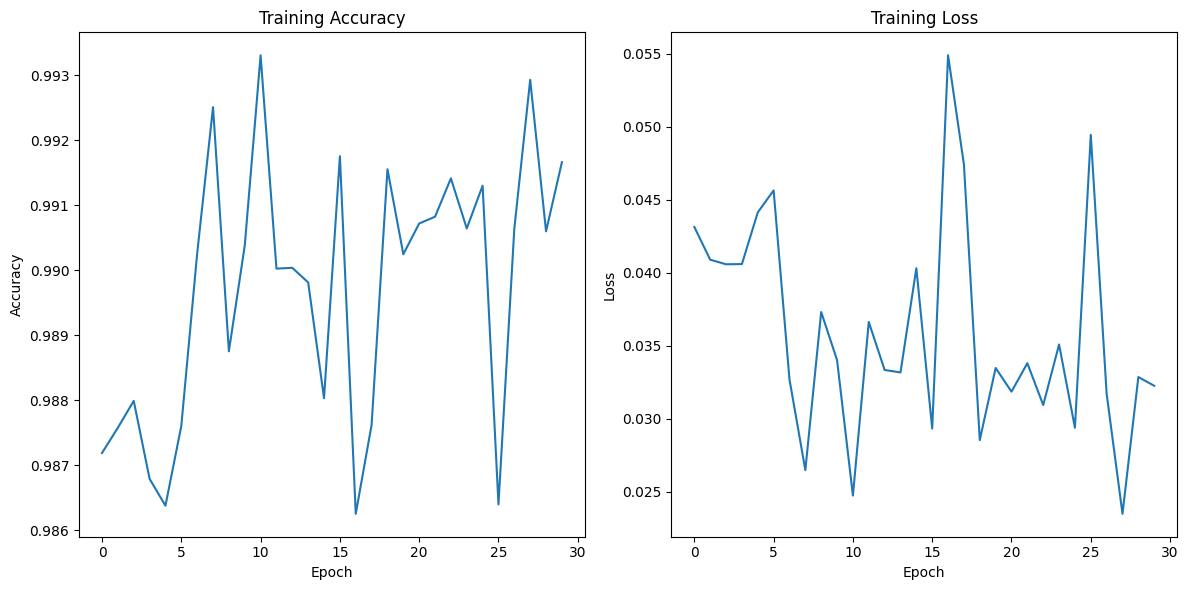

In [ ]:
import matplotlib.pyplot as plt
# Plot training accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
accuracy = lstm_model.evaluate(X_train, y_train_one_hot)[1]
print("Training Accuracy: {:.2f}%".format(accuracy * 100))

7788/7788 [==============================] - 29s 4ms/step - loss: 0.0303 - accuracy: 0.9920
Training Accuracy: 99.20%


In [ ]:
# Print the unique labels in y_test
print(set(y_test))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33}


In [ ]:
# Ensure labels are within the correct range
y_test_clipped = np.clip(y_test, 0, nb_classes - 1)

# Convert labels to one-hot encoding
y_test_one_hot = to_categorical(y_test_clipped, nb_classes)

In [ ]:
y_test_one_hot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
# Evaluate the model on the test set
accuracy = lstm_model.evaluate(X_test, y_test_one_hot)[1]
print("Testing Accuracy: {:.2f}%".format(accuracy * 100))

1932/1932 [==============================] - 5s 2ms/step - loss: 0.0303 - accuracy: 0.9920
Testing Accuracy: 99.20%


1932/1932 [==============================] - 4s 2ms/step


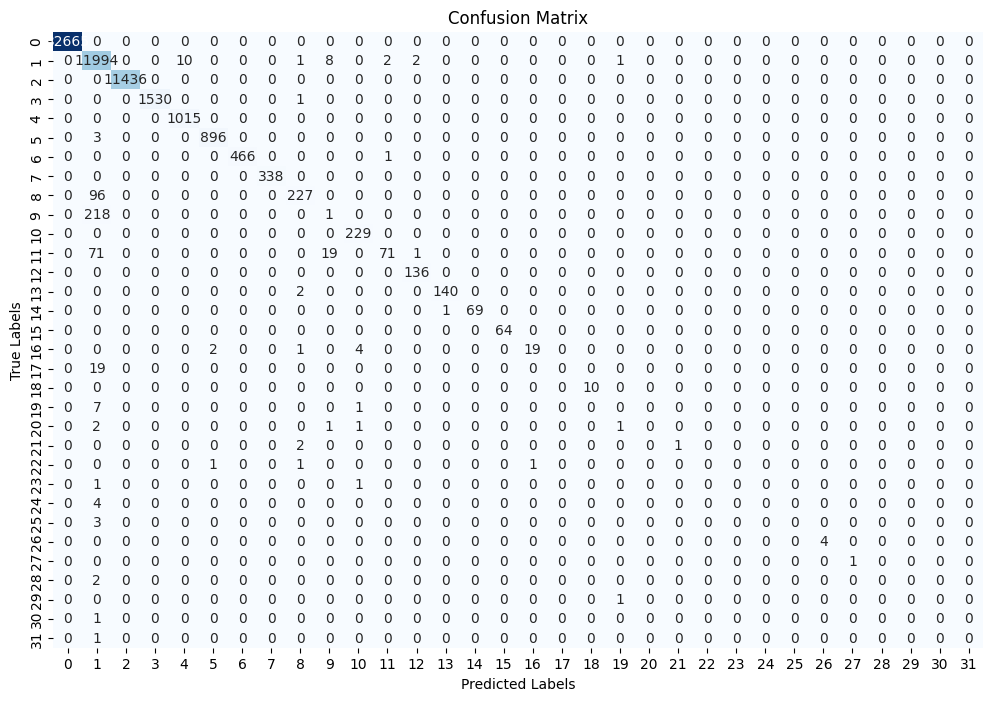

In [ ]:
# Assuming you have obtained predictions
y_pred = lstm_model.predict(X_test)

# Convert one-hot encoded predictions and true labels to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
train_data2.show()

+--------------------+---------+
|        pca_features|label_num|
+--------------------+---------+
|[-0.0105167499963...|      7.0|
|[-0.0103668180958...|     13.0|
|[-0.0103668180958...|     13.0|
|[-0.0103668179734...|     13.0|
|[-0.0103668179734...|     13.0|
|[-0.0103667931627...|      7.0|
|[-0.0103667931627...|      7.0|
|[-0.0103667931627...|      7.0|
|[-0.0103667931627...|      7.0|
|[-0.0103667931627...|      7.0|
|[-0.0103667931627...|      7.0|
|[-0.0103667931627...|      7.0|
|[-0.0103667931627...|      7.0|
|[-0.0103667931627...|      7.0|
|[-0.0103667931627...|      7.0|
|[-0.0103667931627...|      7.0|
|[-0.0103667931627...|      7.0|
|[-0.0103667931627...|      7.0|
|[-0.0103667931627...|      7.0|
|[-0.0103667931627...|      7.0|
+--------------------+---------+
only showing top 20 rows



In [ ]:
# Convert the features column to a DenseVector
vector_assembler = VectorAssembler(inputCols=["pca_features"], outputCol="features_vector")
train_set1 = vector_assembler.transform(train_data2)
test_set1 = vector_assembler.transform(test_data2)
# Convert label_num to integer type
train_set1 = train_set1.withColumn("label_num", col("label_num").cast("integer"))
test_set1 = test_set1.withColumn("label_num", col("label_num").cast("integer"))

# Define the LSTM model
input_dim1 = len(train_set1.select("features_vector").first()[0])
# Convert PySpark DataFrame to Pandas DataFrame
train_data_pd1 = train_set1.select("label_num", "features_vector").toPandas()
test_data_pd1 = test_set1.select("label_num", "features_vector").toPandas()

In [ ]:
# Extract features and labels
X_train1 = train_data_pd1["features_vector"].values.tolist()
y_train1 = train_data_pd1["label_num"].values.tolist()

X_test1 = test_data_pd1["features_vector"].values.tolist()
y_test1 = test_data_pd1["label_num"].values.tolist()

In [ ]:
print(set(y_train1))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37}


In [ ]:
# Set nb_classes to a value greater than or equal to the maximum label value
nb_classes = 38
# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train1, nb_classes)

In [ ]:
lstm_model = create_lstm_model(input_dim1, nb_classes)

In [ ]:
# Convert features to a 3D array (number of samples, time steps, input dimensions)
import numpy as np
X_train1 = np.array(X_train1).reshape((len(X_train1), 1, input_dim1))
X_test1 = np.array(X_test1).reshape((len(X_test1), 1, input_dim1))

In [ ]:
# Set nb_classes to a value greater than or equal to the maximum label value
nb_classes = 38
# Convert labels to one-hot encoding
y_train_one_hot1 = to_categorical(y_train1, nb_classes)

In [ ]:
# Train the LSTM model
history = lstm_model.fit(X_train1, y_train_one_hot1, epochs=30, batch_size=32)

Epoch 1/30
7788/7788 [==============================] - 37s 4ms/step - loss: 0.1595 - accuracy: 0.9640
Epoch 2/30
7788/7788 [==============================] - 36s 5ms/step - loss: 0.0540 - accuracy: 0.9826
Epoch 3/30
7788/7788 [==============================] - 33s 4ms/step - loss: 0.0521 - accuracy: 0.9838
Epoch 4/30
7788/7788 [==============================] - 35s 4ms/step - loss: 0.0508 - accuracy: 0.9850
Epoch 5/30
7788/7788 [==============================] - 34s 4ms/step - loss: 0.0521 - accuracy: 0.9831
Epoch 6/30
7788/7788 [==============================] - 34s 4ms/step - loss: 0.0439 - accuracy: 0.9860
Epoch 7/30
7788/7788 [==============================] - 34s 4ms/step - loss: 0.0454 - accuracy: 0.9850
Epoch 8/30
7788/7788 [==============================] - 34s 4ms/step - loss: 0.0434 - accuracy: 0.9864
Epoch 9/30
7788/7788 [==============================] - 33s 4ms/step - loss: 0.0416 - accuracy: 0.9863
Epoch 10/30
7788/7788 [==============================] - 34s 4ms/step - l

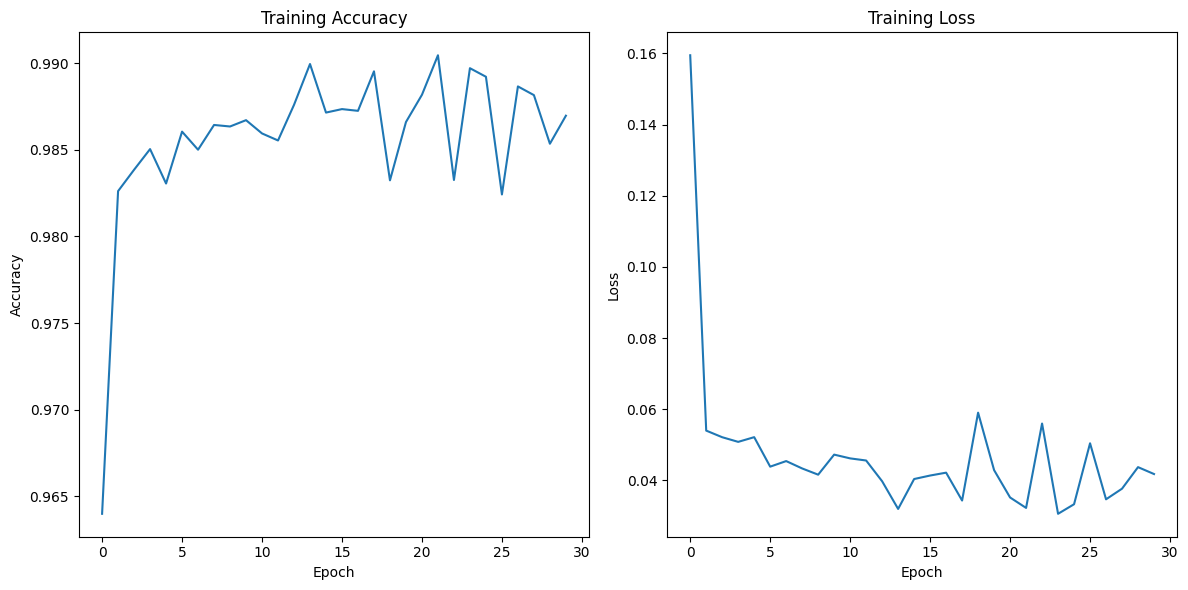

In [ ]:
import matplotlib.pyplot as plt
# Plot training accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
accuracy1 = lstm_model.evaluate(X_train1, y_train_one_hot1)[1]
print("Training Accuracy: {:.2f}%".format(accuracy1 * 100))

7788/7788 [==============================] - 20s 2ms/step - loss: 0.0266 - accuracy: 0.9913
Training Accuracy: 99.13%


In [ ]:
# Print the unique labels in y_test
print(set(y_test1))
# Ensure labels are within the correct range
y_test_clipped = np.clip(y_test1, 0, nb_classes - 1)

# Convert labels to one-hot encoding
y_test_one_hot1 = to_categorical(y_test_clipped, nb_classes)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 36}


1933/1933 [==============================] - 4s 2ms/step - loss: 0.0277 - accuracy: 0.9907
Testing Accuracy: 99.07%
1933/1933 [==============================] - 6s 3ms/step


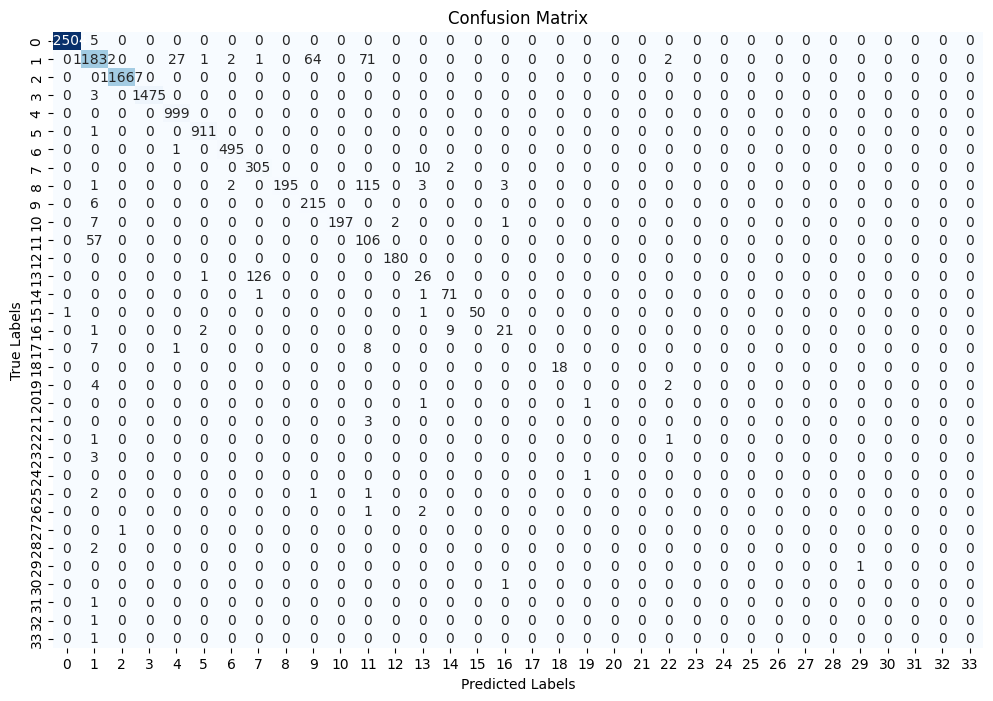

In [ ]:
# Evaluate the model on the test set
accuracy1 = lstm_model.evaluate(X_test1, y_test_one_hot1)[1]
print("Testing Accuracy: {:.2f}%".format(accuracy1 * 100))
# Assuming you have obtained predictions
y_pred1 = lstm_model.predict(X_test1)

# Convert one-hot encoded predictions and true labels to class labels
y_pred_classes1 = np.argmax(y_pred1, axis=1)
y_true_classes1 = np.argmax(y_test_one_hot1, axis=1)

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_true_classes1, y_pred_classes1)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
# Counting occurrences of each unique value in the output column
label_counts = test_data.groupBy("label_num").count().orderBy("label_num")
label_counts.show()

+---------+-----+
|label_num|count|
+---------+-----+
|      0.0|32684|
|      1.0|12040|
|      2.0|11438|
|      3.0| 1542|
|      4.0| 1022|
|      5.0|  874|
|      6.0|  465|
|      7.0|  336|
|      8.0|  332|
|      9.0|  211|
|     10.0|  207|
|     11.0|  157|
|     12.0|  148|
|     13.0|  143|
|     14.0|   69|
|     15.0|   53|
|     16.0|   25|
|     17.0|   22|
|     18.0|   12|
|     19.0|    5|
+---------+-----+
only showing top 20 rows



In [ ]:
# Set the threshold for minimum occurrences
threshold = 90

# Filter the label counts DataFrame to keep only the rows with counts greater than or equal to the threshold
filtered_label_counts = label_counts.filter(label_counts["count"] >= threshold)

# Extract the label numbers that meet the threshold
selected_labels = filtered_label_counts.select("label_num").rdd.flatMap(lambda x: x).collect()

# Filter the training set to keep only the rows with labels that meet the threshold
filtered_train_set = test_data.filter(test_data["label_num"].isin(selected_labels))

# Display the new label counts after filtering
new_label_counts = filtered_train_set.groupBy("label_num").count().orderBy("count", ascending=False)
print("New Label Counts in the Training Set:")
new_label_counts.show(new_label_counts.count(), False)

# Split features and labels in the filtered training set
filtered_train_features = filtered_train_set.select("features")
filtered_train_labels = filtered_train_set.select("label_num")

New Label Counts in the Training Set:
+---------+-----+
|label_num|count|
+---------+-----+
|0.0      |32685|
|1.0      |12062|
|2.0      |11443|
|3.0      |1530 |
|4.0      |1034 |
|5.0      |879  |
|6.0      |486  |
|7.0      |347  |
|8.0      |331  |
|10.0     |208  |
|9.0      |196  |
|11.0     |160  |
|13.0     |142  |
|12.0     |138  |
+---------+-----+



In [ ]:
# Separate features and labels
X_train = filtered_train_features.toPandas()
# Assuming y_train is your Pandas DataFrame
X_train = X_train.sample(frac=1, random_state=42).reset_index(drop=True)
X_train = X_train.iloc[6:]
len(X_train)

61595

In [ ]:
y_train = filtered_train_labels.toPandas()
len(y_train)

61595

In [ ]:
# Separate features and labels
X_train = X_train["features"].tolist()
y_train = y_train["label_num"].tolist()

In [ ]:
# Instantiate ADASYN with optional parameters
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
# Apply ADASYN to the training data
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

In [ ]:
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import col
import pandas as pd
# Combine resampled features and labels into a new DataFrame
resampled_features = [DenseVector(x) for x in X_resampled]
train_set_resampled = spark.createDataFrame(pd.DataFrame(data={"features_dense": resampled_features, "label_num": y_resampled}))
train_set_resampled = train_set_resampled.withColumn("label_num", col("label_num").cast("integer"))

In [ ]:
# Counting occurrences of each unique value in the output column
label_counts = train_set_resampled.groupBy("label_num").count().orderBy("label_num")
label_counts.show()

+---------+-----+
|label_num|count|
+---------+-----+
|        0|32681|
|        1|12040|
|        2|11414|
|        3| 1541|
|        4| 1017|
|        5|  886|
|        6|  465|
|        7|  315|
|        8|  340|
|        9|  219|
|       10|  208|
|       11|  154|
|       12|32625|
|       13|  167|
+---------+-----+



In [ ]:
# Split Data into Train / Test Sets
train_data1, test_data1 = train_set_resampled.randomSplit([.8, .2],seed=1234)

In [ ]:
train_data1.show()

+--------------------+---------+
|      features_dense|label_num|
+--------------------+---------+
|[0.0,0.0,0.0,0.0,...|        0|
|[0.0,0.0,0.0,0.0,...|        0|
|[0.0,0.0,0.0,0.0,...|        0|
|[0.0,0.0,0.0,0.0,...|        0|
|[0.0,0.0,0.0,0.0,...|        0|
|[0.0,0.0,0.0,0.0,...|        0|
|[0.0,0.0,0.0,0.0,...|        0|
|[0.0,0.0,0.0,0.0,...|        0|
|[0.0,0.0,0.0,0.0,...|        1|
|[0.0,0.0,0.0,0.0,...|        0|
|[0.0,0.0,0.0,0.0,...|        0|
|[0.0,0.0,0.0,0.0,...|        0|
|[0.0,0.0,0.0,0.0,...|        0|
|[0.0,0.0,0.0,0.0,...|        7|
|[0.0,0.0,0.0,0.0,...|        3|
|[0.0,0.0,0.0,0.0,...|        0|
|[0.0,0.0,0.0,0.0,...|        0|
|[0.0,0.0,0.0,0.0,...|        0|
|[0.0,0.0,0.0,0.0,...|        0|
|[0.0,0.0,0.0,0.0,...|        0|
+--------------------+---------+
only showing top 20 rows



In [ ]:
# Convert the features column to a DenseVector
vector_assembler = VectorAssembler(inputCols=["features_dense"], outputCol="features_vector")
train_set2 = vector_assembler.transform(train_data1)
test_set2 = vector_assembler.transform(test_data1)
# Convert label_num to integer type
train_set2 = train_set1.withColumn("label_num", col("label_num").cast("integer"))
test_set2 = test_set1.withColumn("label_num", col("label_num").cast("integer"))

# Define the LSTM model
input_dim2 = len(train_set2.select("features_vector").first()[0])
# Convert PySpark DataFrame to Pandas DataFrame
train_data_pd2 = train_set2.select("label_num", "features_vector").toPandas()
test_data_pd2 = test_set2.select("label_num", "features_vector").toPandas()

In [ ]:
# Extract features and labels
X_train2 = train_data_pd2["features_vector"].values.tolist()
y_train2 = train_data_pd2["label_num"].values.tolist()

X_test2 = test_data_pd2["features_vector"].values.tolist()
y_test2 = test_data_pd2["label_num"].values.tolist()

In [ ]:
print(set(y_train2))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37}


In [ ]:
# Set nb_classes to a value greater than or equal to the maximum label value
nb_classes = 38
lstm_model = create_lstm_model(input_dim2, nb_classes)
# Convert features to a 3D array (number of samples, time steps, input dimensions)
import numpy as np
X_train2 = np.array(X_train2).reshape((len(X_train2), 1, input_dim2))
X_test2 = np.array(X_test2).reshape((len(X_test2), 1, input_dim2))

In [ ]:
# Convert labels to one-hot encoding
y_train_one_hot2 = to_categorical(y_train2, nb_classes)

In [ ]:
# Train the LSTM model
history = lstm_model.fit(X_train2, y_train_one_hot2, epochs=30, batch_size=32)

Epoch 1/30
7788/7788 [==============================] - 35s 5ms/step - loss: 0.0817 - accuracy: 0.9785
Epoch 2/30
7788/7788 [==============================] - 33s 4ms/step - loss: 0.0473 - accuracy: 0.9853
Epoch 3/30
7788/7788 [==============================] - 33s 4ms/step - loss: 0.0430 - accuracy: 0.9869
Epoch 4/30
7788/7788 [==============================] - 32s 4ms/step - loss: 0.0482 - accuracy: 0.9847
Epoch 5/30
7788/7788 [==============================] - 32s 4ms/step - loss: 0.0414 - accuracy: 0.9874
Epoch 6/30
7788/7788 [==============================] - 33s 4ms/step - loss: 0.0417 - accuracy: 0.9871
Epoch 7/30
7788/7788 [==============================] - 33s 4ms/step - loss: 0.0452 - accuracy: 0.9867
Epoch 8/30
7788/7788 [==============================] - 33s 4ms/step - loss: 0.0444 - accuracy: 0.9856
Epoch 9/30
7788/7788 [==============================] - 34s 4ms/step - loss: 0.0457 - accuracy: 0.9858
Epoch 10/30
7788/7788 [==============================] - 32s 4ms/step - l

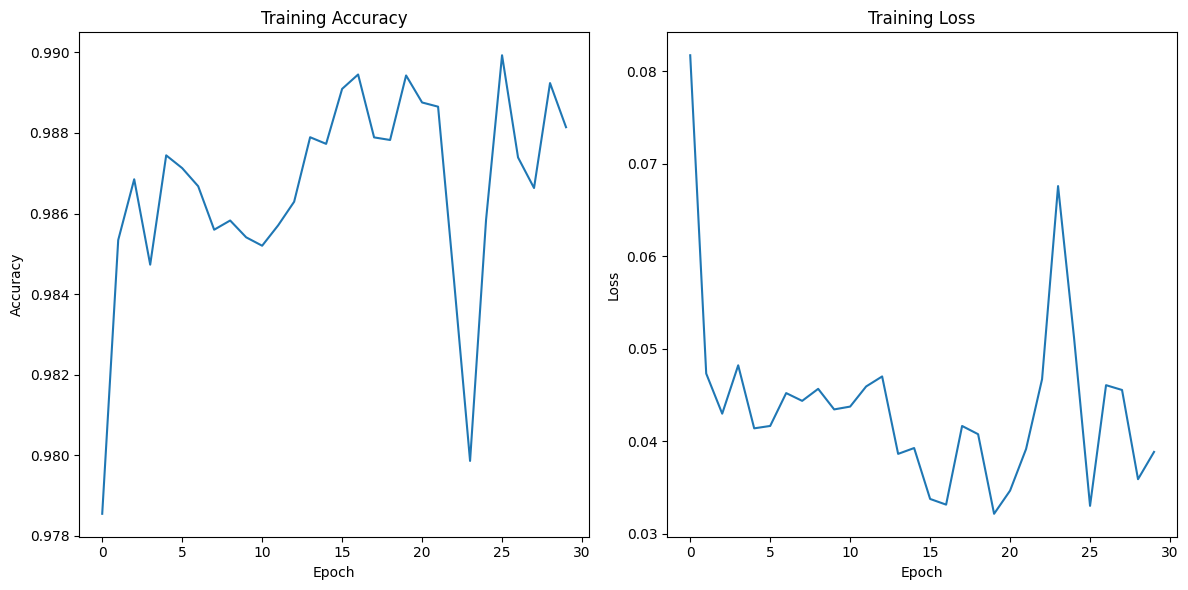

In [ ]:
import matplotlib.pyplot as plt
# Plot training accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
accuracy2 = lstm_model.evaluate(X_train2, y_train_one_hot2)[1]
print("Training Accuracy: {:.2f}%".format(accuracy2 * 100))

7788/7788 [==============================] - 20s 3ms/step - loss: 0.0351 - accuracy: 0.9901
Training Accuracy: 99.01%


In [ ]:
# Print the unique labels in y_test
print(set(y_test2))
# Ensure labels are within the correct range
y_test_clipped = np.clip(y_test2, 0, nb_classes - 1)

# Convert labels to one-hot encoding
y_test_one_hot2 = to_categorical(y_test_clipped, nb_classes)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 34}


1933/1933 [==============================] - 4s 2ms/step - loss: 0.0392 - accuracy: 0.9892
Testing Accuracy: 98.92%
1933/1933 [==============================] - 4s 2ms/step


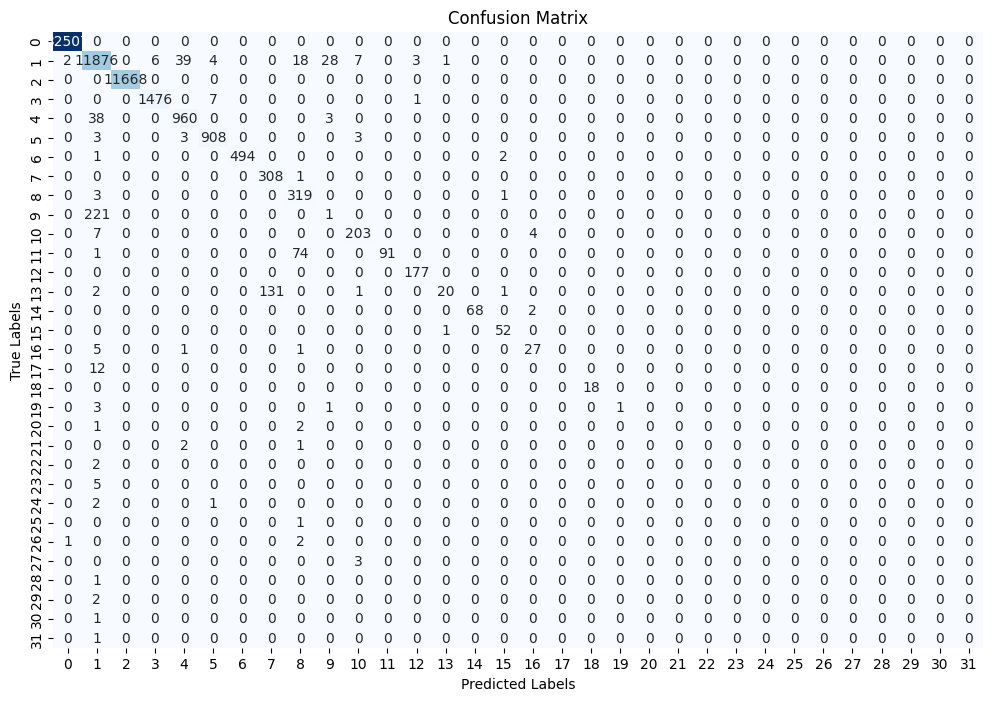

In [ ]:
# Evaluate the model on the test set
accuracy2 = lstm_model.evaluate(X_test2, y_test_one_hot2)[1]
print("Testing Accuracy: {:.2f}%".format(accuracy2 * 100))
# Assuming you have obtained predictions
y_pred2 = lstm_model.predict(X_test2)

# Convert one-hot encoded predictions and true labels to class labels
y_pred_classes2 = np.argmax(y_pred2, axis=1)
y_true_classes2 = np.argmax(y_test_one_hot2, axis=1)

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_true_classes2, y_pred_classes2)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()